# Tutorial Two: Creating an experimental object 

## Introduction: 

The working hourses of IPTK are the classes Experiment, Introduced in this tutorial, and ExperimentalSet, introduced in the next tutorial. The Experimental object act as an anchor point connecting, the identified peptides with the expression value of their parent transcript, with the expression values with the proband metadata and with the HLA allele(s) from which peptides were eluted. We start the tutorial by prepearing the input to the class constructor, then we create an experimental object and finally we use the class API along with analysis and visualization module to demonstrate different analysis methods enabled by the library. 

## Background

To gave some biological insights into the current tutorial, let's start first by describing how the dataset used in this tutorial has been generated. The dataset was obtained from a MoDC cell line incubated with C.albicans lysate for 96 hrs, HLD-DR bound peptides were pulled down using xx antibody, the eluent was measured using Q-Executive machine and peptides were identified from the generated spectra using Proteome Discover and a database compiste of human and candida reference proteins. 

Given the previous background, the following parameters will be used accross database: 

I - tissue name= 'total PBMC'
II - HLA= 'HLA-DRB1*15:01, HLA-DRB1*13:01' 
III - 


## Loading the module

In [3]:
from IPTK.DataStructure.Experiment import Experiment
from IPTK.DataStructure.Database import SeqDB, GeneExpressionDB, CellularLocationDB
from IPTK.DataStructure.Tissue import Tissue
from IPTK.DataStructure.HLASet import HLASet
from IPTK.DataStructure.Proband import Proband
from IPTK.IO.InFunctions import parse_text_table
from IPTK.IO.OutFunctions import write_auto_named_peptide_to_fasta   
from IPTK.DataStructure.Peptide import Peptide 
from IPTK.Visualization.vizTools import plot_peptide_length_dist
from IPTK.Visualization.vizTools import plot_num_peptides_per_parent
from IPTK.Visualization.vizTools import plot_parent_protein_expression_in_tissue
from IPTK.Visualization.vizTools import plot_gene_expression_vs_num_peptides
from IPTK.Visualization.vizTools import plot_num_protein_per_location
from IPTK.Visualization.vizTools import plot_num_peptide_per_go_term
from typing import List 
import pandas as pd 


## Load the Identification Table

In [4]:
table: pd.DataFrame = parse_text_table(path2file='data/HLA_Demo.csv',
                    sep=';', path2fastaDB='data/uniprot_sprot.fasta')

5840 5840 5840 5840


### Create the object needed to build the experimental object 

In [6]:
donor: Proband = Proband(name='Tutorial_2') 
hlas: HLASet = HLASet(hlas=['HLA-DRB1*15:01','HLA-DRB1*13:01'])
seqs: SeqDB = SeqDB(path2fasta='data/uniprot_sprot.fasta')
expresson_profile: GeneExpressionDB= GeneExpressionDB(path2data='../resources/rna_tissue_consensus.tsv')
protein_locations: CellularLocationDB= CellularLocationDB(path2data='../resources/subcellular_location.tsv')
tissue: Tissue = Tissue(name='total PBMC',
                        main_exp_value=expresson_profile, 
                        main_location=protein_locations)

## Construct The Experiment 

In [7]:
exp = Experiment(proband=donor,hla_set=hlas,tissue=tissue,database=seqs,ident_table=table)

In [8]:
print(exp)

an Experimental from proband: Tutorial_2, Tissue: total PBMC
				   With an HLA Class: 2 With
				   3760 peptide identification from 1367 Protein


## Navigating the experiment API 

### Plot the peptide length distribution 

<AxesSubplot:title={'center':'Tutorial-2 peptide length distribution'}, xlabel='Peptide Length', ylabel='Frequency'>

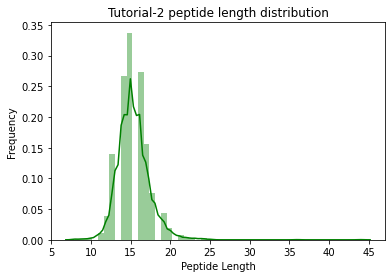

In [9]:
peptide_length: List[int] = exp.get_peptides_length()
# plot the length distribution
visualize_peptide_length_dist(peptide_length,{'color':'green'},title='Tutorial-2 peptide length distribution')

### The number of peptides per protein 

In [10]:
num_per_protein: pd.DataFrame = exp.get_peptides_per_protein()
# show the first 10 elements 
num_per_protein.head(10)

,Proteins,Number_of_Peptides
147,O00560,59
1137,P14618,42
438,P11215,42
1158,P05164,37
379,P01903,36
834,P06396,36
982,P35579,34
491,Q07954,34
571,P07355,33
142,P02768,33


In [11]:
# we can visualize the number of peptides per protein 
visualize_num_peptides_per_parent(num_per_protein)      

NameError: name 'visualize_num_peptides_per_parent' is not defined

In [ ]:
# we can also focus in the first-top 25 protein to get a clearer picture 
visualize_num_peptides_per_parent(num_per_protein,25)

### The gene expression of the parent proteins 

In [ ]:
parent_protein_exp: pd.DataFrame = exp.get_expression_of_parent_proteins()
plot_parent_protein_expression_in_tissue(parent_protein_exp,exp.get_tissue_name())


### Plot the correlation between the gene expression and number of peptides observed

In [ ]:
# get the number of peptides per parent protein 
num_peptides_parent: pd.DataFrame = exp.get_num_peptide_expression_table() 
# print the number of un-mapped genes 
print(f'The number of genes without a reference expression is: {num_peptides_parent.loc[num_peptides_parent.iloc[:,1]==-1].shape[0]}')
# plot the gene expression vs. number of peptides 
plot_gene_expression_vs_num_peptides(num_peptides_parent,tissue_name=exp.get_tissue_name())

### Get the location of the parent proteins

In [ ]:
# get the source protein 
parent_protein_source_loc: pd.DataFrame = exp.get_main_sub_cellular_location_of_parent_proteins()
# print the number of un-mapped genes 
print(f'The number of genes without a known expression is: {parent_protein_source_loc.loc[parent_protein_source_loc.iloc[:,1]==-1].shape[0]}')
# show the head of the table  
print(parent_protein_source_loc.head(10))

In [ ]:
# get the number of proteind in each location 
protein_counts: pd.DataFrame = exp.get_number_of_proteins_per_compartment() 
# plot the number of proteins per-location
plot_num_protein_per_location(protein_counts,exp.get_tissue_name(),drop_unknown=True) 

#### Get the GO of the parent proteins 

In [ ]:
# get the source protein 
parent_protein_go_id: pd.DataFrame = exp.get_go_location_id_parent_proteins()
# print the number of un-mapped genes 
print(f'The number of genes without a known GO Term: {parent_protein_go_id.loc[parent_protein_go_id.iloc[:,1]==-1].shape[0]}')
# show the head of the table  
print(parent_protein_go_id.head(10))

In [ ]:
# get the number of proteind in each location 
protein_counts: pd.DataFrame = exp.get_number_of_proteins_per_go_term()
# plot the number of proteins per-location
plot_num_protein_per_location(protein_counts,exp.get_tissue_name(),drop_unknown=True) 

### plot the number of peptides per Location

In [ ]:
plot_num_protein_per_location(exp.get_num_peptide_per_location(), 
exp.get_tissue_name())

### plot the number of peptides per GO-Term

In [ ]:
plot_num_peptide_per_go_term(exp.get_num_peptide_per_go_term(),
exp.get_tissue_name())

## Work with Peptide object

In [7]:
mono_parental_peptides: List[Peptide] = exp.get_mono_parent_peptides()
print(f'Number of mono-parental peptides: {len(mono_parental_peptides)}')
# print the sequnce of the first 10 peptides 
print('Top 10 peptides: ')
for idx in range(10):
    print('\t'+str(mono_parental_peptides[idx]))

Number of mono-parental peptides: 2773
Top 10 peptides: 
	DGSVIRTIPKDNAQG
	AKSNFEKLSNDLANDA
	GNDPNALRGFHIHQ
	IEGNDPNALRGFHIHQ
	SAQYYVNNAGVSWE
	SAQYYVNNAGVSWED
	SAQYYVNNAGVSWEDG
	GKVVLIAAHGNSLRA
	TSAQYYVNNAGVSWE
	TSAQYYVNNAGVSWED


### Getting The Reduendent, i.e. poly-parental, Peptides In The Database

In [8]:
poly_parental_peptides: List[Peptide] = exp.get_poly_parental_peptides()
print(f'Number of Poly-parental peptides: {len(poly_parental_peptides)}')
# print the sequnce of the first 10 peptides 
print('Top 10 peptides: ')
for idx in range(10):
    print('\t'+str(poly_parental_peptides[idx]))


Number of mono-parental peptides: 987
Top 10 peptides: 
	DGSVIRTIPKDNAQG
	AKSNFEKLSNDLANDA
	GNDPNALRGFHIHQ
	IEGNDPNALRGFHIHQ
	SAQYYVNNAGVSWE
	SAQYYVNNAGVSWED
	SAQYYVNNAGVSWEDG
	GKVVLIAAHGNSLRA
	TSAQYYVNNAGVSWE
	TSAQYYVNNAGVSWED


### Getting the unique, i.e. mono-parental, peptides in the database 

### Getting the peptides with its flanking region from every parent protein

In [10]:
flanking_region: List[str] = exp.get_flanked_peptides(flank_length=8)
# print the the first 10 sequences 
print(f'The total ')
for idx in range(10):
    print(flanking_region[idx])


KDAVTWSVDGSVIRTIPKDNAQGFPQSPMAI
RAIKGVEDAKSNFEKLSNDLANDASKNQKLKD
TTISWEIEGNDPNALRGFHIHQFGDNTNGC
APTTISWEIEGNDPNALRGFHIHQFGDNTNGC
SYTKTCSSNGIFITYKNVPAGYRPFVDA
SYTKTCSSNGIFITYKNVPAGYRPFVDA
SYTKTCSSNGIFITYKNVPAGYRPFVDAY
SYTKTCSSNGIFITYKNVPAGYRPFVDAY
YTWRGGATSAQYYVNNAGVSWEDGCVWGTP
YTWRGGATSAQYYVNNAGVSWEDGCVWGTPG
